In [1]:
import pandas as pd

# 데이터 세트 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


#### 📊 데이터 전처리

In [2]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)

In [3]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])

In [4]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

In [5]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

In [6]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)

### 🌟 1Cycle

#### 🚩 1Cycle 결과
- 회귀  
**MSE: 0.4515, RMSE: 0.6719, MSLE: 0.0030, RMSLE: 0.0552, R2: 0.7668**

- 다중 회귀  
**MSE: 0.3475, RMSE: 0.5895, MSLE: 0.0024, RMSLE: 0.0490, R2: 0.8206**

- 회귀 모델(GradientBoostingRegressor)  
**MSE: 0.3334, RMSE: 0.5774, MSLE: 0.0023, RMSLE: 0.0482, R2: 0.8278**

#### 💡 분석
- 회귀 분석 결과 R2 점수가 약 0.76이 나옴에 따라 선형 패턴을 지니고 있다고 보여졌으나,  
  다중 회귀로 곡선을 부여하였을 때 약 R2 점수가 0.82로 상승함에 따라 완전한 선형은 아니고 비선형의 패턴도 띄고 있음을 확인함.
- 회귀 모델 중 GradientBoostingRegressor을 사용하였을 때, 가장 좋은 성능을 보임에 따라 해당 모델을 선택하는 것이 적합하다고 판단됨.

C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\LEGION\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


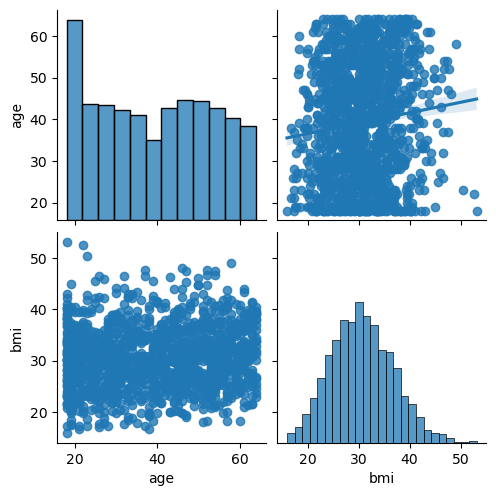

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터프레임에서 'target' 열 제외
columns = ['age', 'bmi']

# 산점도 행렬 시각화
sns.pairplot(enc_m_df[columns], kind="reg")
plt.show()

#### 🚩 결과
- 다중 공선성의 문제가 없는 것을 확인함.

### 🌟 2Cycle

#### 🚩 1Cycle 결과
- 회귀 모델(GradientBoostingRegressor)  
**MSE: 0.3334, RMSE: 0.5774, MSLE: 0.0023, RMSLE: 0.0482, R2: 0.8278**

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 0.3478, RMSE: 0.5897, MSLE: 0.0025, RMSLE: 0.0495, R2: 0.8204**

#### 💡 분석
- 상관관계가 낮은 피처 제거 후 오히려 성능이 저하된 것을 확인함.
- 피처 제거하지 않고 진행하고 validation 분리 후 훈련을 다시 진행하고자 함.

### 🌟 3Cycle

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

#### 📊 CV

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 가장 성능으로 높았던 모델 가져오기
cv_gb_r = GradientBoostingRegressor(random_state=124)

# 파라미터 값 조정
parameters = {'max_depth': [3, 4, 5], 'min_samples_split': [50, 60, 70], 'n_estimators': [40, 50, 60]}

# 하이퍼 파라미터 조정
grid_cv_gb_r = GridSearchCV(cv_gb_r, param_grid=parameters, cv=5, n_jobs=-1)

# 훈련
grid_cv_gb_r.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=124),
             n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'min_samples_split': [50, 60, 70],
                         'n_estimators': [40, 50, 60]})

In [10]:
# 훈련 결과 확인
result_df = pd.DataFrame(grid_cv_gb_r.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.829973,8
1,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.831298,2
2,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.830233,7
3,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.829895,9
4,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.831115,3
5,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.831390,1
6,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.830506,6
7,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.831054,4
8,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.831051,5
9,"{'max_depth': 4, 'min_samples_split': 50, 'n_e...",0.827605,14


In [11]:
# 최적의 모델 담기
cv_gb_r = grid_cv_gb_r.best_estimator_

# 예측
prediction = cv_gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 0.3193, RMSE: 0.5651, MSLE: 0.0022, RMSLE: 0.0471, R2: 0.8351


#### 📊 KFold

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 문제/정답 및 학습/훈련 데이터 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 가장 성능이 우수한 모델 담기
kf_gb_r = GradientBoostingRegressor(random_state=124)

# 파라미터 값 조정
parameters = {'max_depth': [3, 4], 'min_samples_split': [50, 60, 70], 'n_estimators': [40, 50, 60]}

# 교차검증
# n_splits: 데이터를 몇 개의 폴드로 나눌지를 결정 (일반적으로 5 또는 10)
# shuffle: 분할 전 데이터 혼합 여부 
kfold = KFold(n_splits=10, random_state=124, shuffle=True)

# 학습 및 교차 검증 모델 설정
grid_kf_gb_r = GridSearchCV(kf_gb_r, param_grid=parameters, cv=kfold, n_jobs=-1)

# 훈련
grid_kf_gb_r.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=124, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=124), n_jobs=-1,
             param_grid={'max_depth': [3, 4], 'min_samples_split': [50, 60, 70],
                         'n_estimators': [40, 50, 60]})

In [13]:
# 훈련 결과 확인
result_df = pd.DataFrame(grid_kf_gb_r.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
display(result_df)

,params,mean_test_score,rank_test_score
0,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.834166,9
1,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.835076,5
2,"{'max_depth': 3, 'min_samples_split': 50, 'n_e...",0.835288,2
3,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.834302,8
4,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.835003,6
5,"{'max_depth': 3, 'min_samples_split': 60, 'n_e...",0.835090,4
6,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.834470,7
7,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.835165,3
8,"{'max_depth': 3, 'min_samples_split': 70, 'n_e...",0.835396,1
9,"{'max_depth': 4, 'min_samples_split': 50, 'n_e...",0.832708,12


In [14]:
# 최적의 모델 담기
kf_gb_r = grid_kf_gb_r.best_estimator_

# 예측
prediction = kf_gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 0.3211, RMSE: 0.5667, MSLE: 0.0022, RMSLE: 0.0473, R2: 0.8342


#### 🚩 1Cycle 결과
- 회귀 모델(GradientBoostingRegressor)  
**MSE: 0.3334, RMSE: 0.5774, MSLE: 0.0023, RMSLE: 0.0482, R2: 0.8278**

#### 🚩 3Cycle 결과
- Validation (cv)  
**MSE: 0.3193, RMSE: 0.5651, MSLE: 0.0022, RMSLE: 0.0471, R2: 0.8351**

- Validation (K-Fold)  
**MSE: 0.3211, RMSE: 0.5667, MSLE: 0.0022, RMSLE: 0.0473, R2: 0.8342**

#### 💡 분석
- validation 후 성능이 더 향상된 것으로 나타났으며, cv로 분리하는 것이 더 적합하다고 판단됨.
- 0.8 이상은 과적합이 우려되기 때문에 규제를 통해 과적합 조정이 필요할 것으로 보이며, 차원 축소 시 성능이 어떻게 조정되는지 확인하기로 함.